<a href="https://colab.research.google.com/github/Idan707/Kaggle_TMDB_Box_Office_Prediction/blob/master/Kaggle_TMDB_Box_Office_Prediction_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone the entire repo.
!git clone -l -s git://github.com/Idan707/Kaggle_TMDB_Box_Office_Prediction.git cloned-repo
%cd cloned-repo
# !ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 195 (delta 104), reused 85 (delta 34), pack-reused 0
Receiving objects: 100% (195/195), 25.06 MiB | 6.82 MiB/s, done.
Resolving deltas: 100% (104/104), done.
/content/cloned-repo


In [2]:
#pip install pandas==0.25
pip install catboost

     |████████████████████████████████| 64.4MB 59kB/s 


# Import & Load

In [0]:
# imports
import pandas as pd
import  numpy as np
import ast
import json
import gensim
import datetime
import ast
import nltk
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.preprocessing import MultiLabelBinarizer ,normalize
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
import lightgbm as lgb
import catboost as cat
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GroupKFold
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# set display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

# read raw data
train = pd.read_csv('/content/cloned-repo/Data/train.csv',
                    parse_dates=['release_date'])
test = pd.read_csv('/content/cloned-repo/Data/test.csv',
                    parse_dates=['release_date'])

# The data below comes from the kernel EDA, Feature Engineering, LGB+XGB+CAT of Kamal Chhirang
trainAdditionalFeatures = pd.read_csv('/content/cloned-repo/Data/TrainAdditionalFeatures.csv')[['imdb_id','popularity2','rating','totalVotes']]
testAdditionalFeatures = pd.read_csv('/content/cloned-repo/Data/TestAdditionalFeatures.csv')[['imdb_id','popularity2','rating','totalVotes']]

train = pd.merge(train, trainAdditionalFeatures, how='left', on=['imdb_id'])
test = pd.merge(test, testAdditionalFeatures, how='left', on=['imdb_id'])

# From https://www.kaggle.com/zero92/tmdb-prediction/data
release_dates = pd.read_csv('//content/cloned-repo/Data/release_dates_per_country.csv')
release_dates['id'] = range(1,7399)
release_dates.drop(['original_title','title'],axis = 1,inplace = True)
release_dates.index = release_dates['id']

release_dates.drop('id',axis = 1,inplace = True)
train = pd.merge(train, release_dates, how='left', on=['id'], left_index=False, right_index=True)
test = pd.merge(test, release_dates, how='left', on=['id'], left_index=False, right_index=True)

# Date Fix
train['release_date'] = train['release_date'].mask(train['release_date'].dt.year > 2017, 
                                                   train['release_date'] - pd.offsets.DateOffset(years=100))
test['release_date'] = test['release_date'].mask(test['release_date'].dt.year > 2017, 
                                                   test['release_date'] - pd.offsets.DateOffset(years=100))

test['revenue'] = 0
#train.index = train['id']
#test.index = test['id']

mlb = MultiLabelBinarizer()

In [0]:
train.loc[train['id'] == 16,'revenue'] = 192864         
train.loc[train['id'] == 90,'budget'] = 30000000                  
train.loc[train['id'] == 118,'budget'] = 60000000       
train.loc[train['id'] == 149,'budget'] = 18000000       
train.loc[train['id'] == 313,'revenue'] = 12000000       
train.loc[train['id'] == 451,'revenue'] = 12000000      
train.loc[train['id'] == 464,'budget'] = 20000000       
train.loc[train['id'] == 470,'budget'] = 13000000       
train.loc[train['id'] == 513,'budget'] = 930000         
train.loc[train['id'] == 797,'budget'] = 8000000        
train.loc[train['id'] == 819,'budget'] = 90000000       
train.loc[train['id'] == 850,'budget'] = 90000000       
train.loc[train['id'] == 1007,'budget'] = 2              
train.loc[train['id'] == 1112,'budget'] = 7500000       
train.loc[train['id'] == 1131,'budget'] = 4300000        
train.loc[train['id'] == 1359,'budget'] = 10000000       
train.loc[train['id'] == 1542,'budget'] = 1             
train.loc[train['id'] == 1570,'budget'] = 15800000       
train.loc[train['id'] == 1571,'budget'] = 4000000        
train.loc[train['id'] == 1714,'budget'] = 46000000       
train.loc[train['id'] == 1721,'budget'] = 17500000       
train.loc[train['id'] == 1865,'revenue'] = 25000000      
train.loc[train['id'] == 1885,'budget'] = 12             
train.loc[train['id'] == 2091,'budget'] = 10             
train.loc[train['id'] == 2268,'budget'] = 17500000       
train.loc[train['id'] == 2491,'budget'] = 6              
train.loc[train['id'] == 2602,'budget'] = 31000000       
train.loc[train['id'] == 2612,'budget'] = 15000000       
train.loc[train['id'] == 2696,'budget'] = 10000000      
train.loc[train['id'] == 2801,'budget'] = 10000000       
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9              
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30

# Feature Engineering 

In [38]:
def convert_string_to_list(strVal):
    if type(strVal) is not str:
        return  []
    else:
        return ast.literal_eval(strVal)
    
def format_dict_column_and_extract_names(strVal, col="name"):
    listOfItems = convert_string_to_list(strVal)

    return list(map(lambda x: x[col], listOfItems))

def add_x_length_column(df, col):
    df[col + '_size'] = df[col].apply(lambda x: len(x))
    
    return df

def extract_genres(df):
    df['genres'] = df['genres'].apply(format_dict_column_and_extract_names)
    df = add_x_length_column(df, col='genres')
    temp = mlb.fit_transform(df.pop('genres'))
    temp_df = pd.DataFrame(temp, columns=list(map(lambda x: 'genres'+'_'+x,mlb.classes_)), 
                              )#index=temp.index)
    #print('extract_genres temp df shape: ', temp_df.shape)
    df = pd.merge(df, temp_df, how='inner', on=df.id)
    
    return df

def extract_common(df, col, limit, apply_dict_to_col=True):
    if apply_dict_to_col == True:
        df[col] = df[col].apply(format_dict_column_and_extract_names)
        
    companiesCount = df[col].apply(pd.Series).stack().value_counts().sort_values(axis=0, ascending=False)
    companiesToKeep = companiesCount[:limit].keys()
    
    add_x_length_column(df, col)
    df[col] = df[col].apply(lambda x: list(filter(lambda i: i in companiesToKeep, x)))
    
    temp = mlb.fit_transform(df.pop(col))
    temp_df = pd.DataFrame(temp, columns=list(map(lambda x: col+'_'+x,mlb.classes_)), 
                              )#index=temp.index)
    #print('extract_common temp df shape: ', temp_df.shape)
    #print('temp index: ',temp_df.index)
    df = pd.merge(df, temp_df, how='inner', left_index=True, right_index=True)

    return df

def last_year_metrics(df, agg_col='release_date_Year', calc_col=['revenue','imdb_id','popularity','budget'], leg=1):
    
    temp = df.groupby([agg_col]).agg(last_period_mean_revenue = (calc_col[0], 'mean'),
                                     last_period_median_revenue = (calc_col[0], 'median'),
                                     last_period_movies_count = (calc_col[1], 'count'),
                                     last_period_mean_popularity = (calc_col[2], 'mean'),
                                     last_period_median_popularity = (calc_col[2], 'median'),
                                     last_period_mean_budget = (calc_col[3], 'mean'),
                                     last_period_median_budget = (calc_col[3], 'median')).shift(leg).reset_index()

    return pd.merge(df, temp, on=['release_date_Year'], how='left')

def days_diff_from_last_movie(df, col='release_date'):#see if there is a need in buckts
    df = df.sort_values(by=[col])
    df['days_diff_from_last_movie'] = df[col].diff().fillna(0).dt.days
    
    return df

def ratios(df):
    df['budget_to_runtime'] = df['budget']/df['runtime']
    df['budget_to_cast_crew_size'] = df['budget']/(df['cast_size'] + df['crew_size'])
    df['budget_to_popularity'] = df['budget']/df['popularity']
    
    df['budget_to_year'] = df['budget'] / df['release_date_Year']
    df['budget_to_popularity_to_log_budget'] = df['budget_to_popularity'] / df['log_budget']
    df['year_to_log_budget'] = df['release_date_Year'] / df['log_budget']
    df['budget_to_runtime_to_year'] = df['budget_to_runtime'] / df['release_date_Year']
    
    return df

def add_datepart(df,col ='release_date'):
    df[col] = pd.to_datetime(df[col])
    df[col +'_Year']  = df[col].dt.year
    df[col +'_Month'] = df[col].dt.month
    df[col +'_day_of_month'] = df[col].dt.day
    df[col +'_week_day'] = df[col].dt.dayofweek
    df[col +'_is_quarter_start'] = df[col].dt.is_quarter_start
    df[col +'_is_quarter_start'] = df[col +'_is_quarter_start'].fillna(False)
    
    return df 

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
            
    return result

def extract_common_overview_words(df, col):
    df[col] = df[col].fillna('').astype(str).map(preprocess)
    df[col] = df[col].map(lambda x: list(set(x)))
    df = extract_common(df, col, limit=15, apply_dict_to_col=False)
    
    return df
  
def extract_gender(strVal, dict_key, dict_value):
    listOfItems = convert_string_to_list(strVal)

    Item = (list(filter(lambda lst: lst[dict_key] == dict_value, listOfItems)) or [None])[0]
    if type(Item) is dict:
        return Item['gender']
    else:
        return None
      
def add_gender(df, col, dict_key_in , dict_value_in):
    df[dict_key_in + '_' + str(dict_value_in) + '_gender'] = df[col].apply(extract_gender, args=[dict_key_in, dict_value_in])
    df[dict_key_in + '_' + str(dict_value_in) + '_gender'] = df[dict_key_in + '_' + str(dict_value_in) + '_gender'].fillna(2).astype('int64')
    
    return df

def std_avg_features(df, agg_col, calc_col):
    temp = df.groupby([agg_col], as_index=True).agg(mean_pop = (calc_col, 'mean'),
                                                    std_pop = (calc_col, 'std')).fillna(0)

    df = df.merge(temp, 'left', on=agg_col)
    df['zscore_pop_year'] = (df[calc_col] - df['mean_pop'])/ df['std_pop']
    df['zscore_pop_year'] = df['zscore_pop_year'].apply(abs).fillna(0)
    
    return df


def run_main(train, test):

  test['train_test'] = 'test'  
  train['train_test'] = 'train'

  # work on full df
  print('working on full df..')
  df = pd.concat([train, test],axis=0, sort=True)
  df = extract_genres(df)
  df = extract_common(df, col='production_companies', limit=10)
  df = extract_common(df, col='production_countries', limit=10)
  df = extract_common(df, col='spoken_languages', limit=10)
  df = extract_common(df, col='Keywords', limit=10)
  
  df = add_gender(df, col='crew', dict_key_in='job', dict_value_in='Producer')
  df = add_gender(df, col='crew', dict_key_in='job', dict_value_in='Director')
  df = add_gender(df, col='cast', dict_key_in='order', dict_value_in=0)
  df = add_gender(df, col='cast', dict_key_in='order', dict_value_in=1)
  df = extract_common(df, col='cast', limit=10)
  df = extract_common(df, col='crew', limit=10)

  # fill missing values 1
  print('fill missing values 1...')
  df['cast_size'] = np.where(df['cast_size'] == 0, df['cast_size'].mean(), df['cast_size'])
  df['crew_size'] = np.where(df['crew_size'] == 0, df['crew_size'].mean(), df['crew_size'])
  
  # add datepart
  print('add datepart...')
  df = add_datepart(df,col = 'release_date') 

  # add std avg zscore features
  print('add zscore features...')
  df = std_avg_features(df, agg_col='release_date_Year', calc_col='popularity')

  # split for data leak prevention
  print('split for data leak prevention and run main...')
  train = df[df['train_test'] == 'train']
  test = df[df['train_test'] == 'test']

  train = last_year_metrics(train)
  train = days_diff_from_last_movie(train)
  train['revenue'] = np.where(train['revenue'] == 0, train['last_period_median_revenue'], train['revenue'])
  train['revenue'] = np.where(train['revenue'] == 0, train["revenue"].mean(), train['revenue'])
  train = extract_common_overview_words(train, col='overview')

  test = last_year_metrics(test)
  test = days_diff_from_last_movie(test)
  test['revenue'] = np.where(test['revenue'] == 0, test['last_period_median_revenue'], test['revenue'])
  test['revenue'] = np.where(test['revenue'] == 0, test["revenue"].mean(), test['revenue'])
  test = extract_common_overview_words(test, col='overview')

  # addtion by https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation
  train['log_budget'] = np.log1p(train['budget'])
  test['log_budget'] = np.log1p(test['budget'])
  train['has_homepage'] = 0
  train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
  test['has_homepage'] = 0
  test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1
  df['isMovieReleased'] = 1
  df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0

  df = pd.concat([train, test],axis=0, sort=True)
  # end addion

  # fill missing values 2
  print('fill missing values 2...')
  df['budget'] = np.where(df['budget'] == 0, df['last_period_median_budget'], df['budget'])
  df['budget'] = np.where(df['budget'] == 0, df["budget"].mean(), df['budget'])
  df['production_companies_size'] = np.where(df['production_companies_size'] == 0, df["production_companies_size"].mean(), df['production_companies_size'])
  df['production_countries_size'] = np.where(df['production_countries_size'] == 0, df["production_countries_size"].mean(), df['production_countries_size'])
  df['Keywords_size'] = np.where(df['Keywords_size'] == 0, df["Keywords_size"].mean(), df['Keywords_size'])

  # run ratios
  print('run ratios...')
  df = ratios(df)

  # fill missing values 3
  print('fill missing values 3...')
  df = df.replace([np.inf, -np.inf], np.nan)
  df['budget_to_runtime'] = np.where(df['budget_to_runtime'] == np.nan, df["budget_to_runtime"].mean(), df['budget_to_runtime'])
  df['belongs_to_collection_bool'] = np.where(df['belongs_to_collection'].isna(), 0, 1)
  df.drop(['belongs_to_collection'], axis=1, inplace=True)
  df["budget_to_popularity"] = np.where(df['budget_to_popularity'] == np.nan, df["budget_to_popularity"].mean(), df['budget_to_popularity'])

  # counting the numbers of words in the movie title 
  print('counting the numbers of words in the movie title..')
  df['original_title_words'] = df.original_title.str.split()
  df['original_title_words'] = df['original_title_words'].apply(lambda x: len(x))

  df = pd.get_dummies(df, prefix=['job_Producer_gender', 'job_Director_gender', 'order_0_gender', 'order_1_gender'], 
                          columns=['job_Producer_gender', 'job_Director_gender', 'order_0_gender', 'order_1_gender'])

  # removing highly correlated features
  print('removing highly correlated features...')
  df.drop(["release_date_Year", "genres_TV Movie", "last_period_mean_revenue", 
           'last_period_median_revenue', 'overview_wife', 'overview_year'], inplace=True, axis=1)

  # normalize features
  #scaler = preprocessing.power_transform()
  df["budget_to_popularity"] = preprocessing.power_transform(df[["budget_to_popularity"]])

  return df

df = run_main(train, test)
df.head()

working on full df..
fill missing values 1...
add datepart...
add zscore features...
split for data leak prevention and run main...
fill missing values 2...
run ratios...
fill missing values 3...
counting the numbers of words in the movie title..
removing highly correlated features...


,AR,AT,AU,BE,BG,CA,CL,CZ,DE,DK,FI,FR,GB,GR,HK,HU,ID,IE,IL,IS,IT,KW,KZ,Keywords_aftercreditsstinger,Keywords_based on novel,Keywords_duringcreditsstinger,Keywords_independent film,Keywords_love,Keywords_murder,Keywords_revenge,Keywords_sex,Keywords_size,Keywords_violence,Keywords_woman director,LV,MX,NL,NO,PE,PL,PT,RU,SE,SI,SK,TH,TR,TW,UA,US,budget,cast_Bruce Willis,cast_Liam Neeson,cast_Matt Damon,cast_Morgan Freeman,cast_Nicolas Cage,cast_Robert De Niro,cast_Samuel L. Jackson,cast_Steve Buscemi,cast_Sylvester Stallone,cast_Willem Dafoe,cast_size,crew_Avy Kaufman,crew_Bob Weinstein,crew_Deborah Aquila,crew_Hans Zimmer,crew_Harvey Weinstein,crew_James Newton Howard,crew_Mary Vernieu,crew_Robert Rodriguez,crew_Steven Spielberg,crew_Tricia Wood,crew_size,days_diff_from_last_movie,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,genres_History,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_Thriller,genres_War,genres_Western,genres_size,has_homepage,homepage,id,imdb_id,key_0,last_period_mean_budget,last_period_mean_popularity,last_period_median_budget,last_period_median_popularity,last_period_movies_count,log_budget,mean_pop,movie_id,original_language,original_title,overview_family,overview_father,overview_film,overview_finds,overview_friends,overview_help,overview_life,overview_love,overview_size,overview_story,overview_time,overview_woman,overview_world,overview_years,overview_young,popularity,popularity2,poster_path,production_companies_Columbia Pictures,production_companies_Columbia Pictures Corporation,production_companies_Metro-Goldwyn-Mayer (MGM),production_companies_New Line Cinema,production_companies_Paramount Pictures,production_companies_Touchstone Pictures,production_companies_Twentieth Century Fox Film Corporation,production_companies_Universal Pictures,production_companies_Walt Disney Pictures,production_companies_Warner Bros.,production_companies_size,production_countries_Australia,production_countries_Canada,production_countries_France,production_countries_Germany,production_countries_India,production_countries_Italy,production_countries_Japan,production_countries_Spain,production_countries_United Kingdom,production_countries_United States of America,production_countries_size,rating,release_date,release_date_Month,release_date_day_of_month,release_date_is_quarter_start,release_date_week_day,release_year,revenue,runtime,spoken_languages_,spoken_languages_Deutsch,spoken_languages_English,spoken_languages_Español,spoken_languages_Français,spoken_languages_Italiano,spoken_languages_Pусский,spoken_languages_size,spoken_languages_हिन्दी,spoken_languages_日本語,spoken_languages_普通话,status,std_pop,tagline,theatrical,theatrical_limited,title,totalVotes,train_test,zscore_pop_year,budget_to_runtime,budget_to_cast_crew_size,budget_to_popularity,budget_to_year,budget_to_popularity_to_log_budget,year_to_log_budget,budget_to_runtime_to_year,belongs_to_collection_bool,original_title_words,job_Producer_gender_0,job_Producer_gender_1,job_Producer_gender_2,job_Director_gender_0,job_Director_gender_1,job_Director_gender_2,order_0_gender_0,order_0_gender_1,order_0_gender_2,order_1_gender_0,order_1_gender_1,order_1_gender_2
1763,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0,0,0,0,0,0,14.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,250000.00,0,0,0,0,0,0,0,0,0,0,35.00,0,0,0,0,0,0,0,0,0,0,12.00,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,NaN,1764,tt0012349,1764,nan,nan,nan,nan,nan,12.43,8.17,826.00,en,The Kid,0,0,0,0,0,0,0,0,28,0,0,0,1,0,0,8.17,8.66,/drgMcyTsySQBnUPGaBThCHGdlWT.jpg,0,0,0,0,0,0,0,0,0,0,2.00,0,0,0,0,0,0,0,0,0,1,1.00,8.20,1921-01-21,1.00,21.00,False,4.00,1957.00,2500000.00,68.00,0,0,0,0,0,0,0,1,0,0,0,Released,0.00,6 reels of Joy.,12.00,1.00,The Kid,760.00,train,0.00,3676.47,

# Modeling

In [0]:
model_df = df.copy()
model_df = model_df.drop(["homepage", "imdb_id", "movie_id", "original_language", "original_title", "poster_path", "release_date", "status", "tagline", "title", "key_0"], axis=1)

train = model_df[model_df['train_test'] == 'train']
test = model_df[model_df['train_test'] == 'test']

train = train.drop(['train_test'],axis=1)
test = test.drop(['train_test'] ,axis=1)

def score(data, y):
    validation_res = pd.DataFrame(
    {"id": data["id"].values,
     "transactionrevenue": data["revenue"].values,
     "predictedrevenue": np.expm1(y)}) 
    validation_res = validation_res.groupby("id")["transactionrevenue", "predictedrevenue"].sum().reset_index()

    return  np.sqrt(mean_squared_error((np.log1p(validation_res["transactionrevenue"].values)), 
                                     (np.log1p(validation_res["predictedrevenue"].values))))
    
class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['id'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['id'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['id'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 500, "verbose": 1000, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["revenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["revenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking:
                train[name].iloc[val] = np.expm1(predictions)
                
                test_predictions = model.predict(test[features])
                #print(test_predictions)
                test_predictions[test_predictions < 0] = 0
                test[name] += np.expm1(test_predictions) / len(self.fold_ids)
                
        print("Final rmsle score: ", full_score)
        return full_score


## Models config

In [0]:
lgbmodel = lgb.LGBMRegressor(n_estimators=20000, 
                             objective='regression', 
                             metric='rmse',
                             max_depth = 15,
                             num_leaves=30, 
                             min_child_samples=100,
                             learning_rate=0.001,
                             boosting = 'gbdt',
                             min_data_in_leaf= 10,
                             feature_fraction = 0.2,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2,
                             bagging_seed=42, 
                             subsample=.8, 
                             colsample_bytree=.9,
                             use_best_model=True)

xgbmodel = xgb.XGBRegressor(max_depth=10, 
                            learning_rate=0.01, 
                            n_estimators=20000, 
                            objective='reg:linear', 
                            gamma=1.45, 
                            seed=42, 
                            silent=True,
                            subsample=0.7, 
                            colsample_bytree=0.8, 
                            colsample_bylevel=0.50)

catmodel = cat.CatBoostRegressor(iterations=5000, 
                                 learning_rate=0.01, 
                                 depth=6,
                                 loss_function = "RMSE",
                                 boost_from_average = True,
                                 colsample_bylevel=0.8,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 random_seed=2345,
                                 l2_leaf_reg = 0.2)

In [0]:
Kfolder = KFoldValidation(train)

In [43]:
Kfolder.validate(train, test, train.columns.drop(['revenue','id']) , lgbmodel, name="lgbfinal", prepare_stacking=True) 

Fold  0 :
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's rmse: 2.42903
[2000]	valid_0's rmse: 2.23154
[3000]	valid_0's rmse: 2.16748
[4000]	valid_0's rmse: 2.13929
[5000]	valid_0's rmse: 2.1233
[6000]	valid_0's rmse: 2.11278
[7000]	valid_0's rmse: 2.10615
[8000]	valid_0's rmse: 2.1019
[9000]	valid_0's rmse: 2.09902
[10000]	valid_0's rmse: 2.09712
[11000]	valid_0's rmse: 2.09523
[12000]	valid_0's rmse: 2.09425
[13000]	valid_0's rmse: 2.09367
[14000]	valid_0's rmse: 2.09311
[15000]	valid_0's rmse: 2.09284
Early stopping, best iteration is:
[15374]	valid_0's rmse: 2.09266
Fold  0  error:  2.092655409368243
Fold  0  score:  2.092655409368243
Fold  1 :
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's rmse: 2.05701
[2000]	valid_0's rmse: 1.83021
[3000]	valid_0's rmse: 1.75495
[4000]	valid_0's rmse: 1.72213
[5000]	valid_0's rmse: 1.70322
[6000]	valid_0's rmse: 1.69258
[7000]	valid_0's rmse: 1.68505
[8000]	valid_0's rmse: 1.68053


1.7898647510695078

In [44]:
Kfolder.validate(train, test, train.columns.drop(['revenue','id']), xgbmodel, name="xgbfinal", prepare_stacking=True)

Fold  0 :
[0]	validation_0-rmse:15.5537
Will train until validation_0-rmse hasn't improved in 500 rounds.
Stopping. Best iteration:
[475]	validation_0-rmse:2.17312

Fold  0  error:  2.1731188820004315
Fold  0  score:  2.1731188820004315
Fold  1 :
[0]	validation_0-rmse:15.5632
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:1.72848
Stopping. Best iteration:
[643]	validation_0-rmse:1.72258

Fold  1  error:  1.7225771522212843
Fold  1  score:  1.722577152221284
Fold  2 :
[0]	validation_0-rmse:15.5231
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:1.69656
Stopping. Best iteration:
[655]	validation_0-rmse:1.69076

Fold  2  error:  1.6907630380989793
Fold  2  score:  1.690763038248795
Fold  3 :
[0]	validation_0-rmse:15.7841
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:1.69173
Stopping. Best iteration:
[637]	validation_0-rmse:1.68938

Fold  3  error:  1.68937711

1.8749520192996147

In [45]:
Kfolder.validate(train, test, train.columns.drop(['revenue','id']) , catmodel, name="catfinal", prepare_stacking=True,
               fit_params={"use_best_model": True, "verbose": 1000})

Fold  0 :
0:	learn: 2.9884528	test: 3.1378976	best: 3.1378976 (0)	total: 10.9ms	remaining: 54.7s
1000:	learn: 1.2920477	test: 2.1293260	best: 2.1208085 (525)	total: 9.92s	remaining: 39.6s
2000:	learn: 0.9029102	test: 2.1205289	best: 2.1200425 (1820)	total: 20s	remaining: 29.9s
3000:	learn: 0.6592627	test: 2.1239910	best: 2.1172149 (2238)	total: 30s	remaining: 20s
4000:	learn: 0.4946065	test: 2.1241586	best: 2.1172149 (2238)	total: 40.1s	remaining: 10s
4999:	learn: 0.3790445	test: 2.1221551	best: 2.1172149 (2238)	total: 50.2s	remaining: 0us

bestTest = 2.11721489
bestIteration = 2238

Shrink model to first 2239 iterations.
Fold  0  error:  2.117214911960056
Fold  0  score:  2.117214911960056
Fold  1 :
0:	learn: 3.0708560	test: 2.8125194	best: 2.8125194 (0)	total: 11.2ms	remaining: 55.8s
1000:	learn: 1.3736821	test: 1.7084906	best: 1.6974677 (436)	total: 10.3s	remaining: 41.2s
2000:	learn: 0.9501729	test: 1.7156436	best: 1.6974677 (436)	total: 20.6s	remaining: 30.9s
3000:	learn: 0.691953

1.821960673818377

# Model Stacking

In [46]:
train.head(5)

,AR,AT,AU,BE,BG,CA,CL,CZ,DE,DK,FI,FR,GB,GR,HK,HU,ID,IE,IL,IS,IT,KW,KZ,Keywords_aftercreditsstinger,Keywords_based on novel,Keywords_duringcreditsstinger,Keywords_independent film,Keywords_love,Keywords_murder,Keywords_revenge,Keywords_sex,Keywords_size,Keywords_violence,Keywords_woman director,LV,MX,NL,NO,PE,PL,PT,RU,SE,SI,SK,TH,TR,TW,UA,US,budget,cast_Bruce Willis,cast_Liam Neeson,cast_Matt Damon,cast_Morgan Freeman,cast_Nicolas Cage,cast_Robert De Niro,cast_Samuel L. Jackson,cast_Steve Buscemi,cast_Sylvester Stallone,cast_Willem Dafoe,cast_size,crew_Avy Kaufman,crew_Bob Weinstein,crew_Deborah Aquila,crew_Hans Zimmer,crew_Harvey Weinstein,crew_James Newton Howard,crew_Mary Vernieu,crew_Robert Rodriguez,crew_Steven Spielberg,crew_Tricia Wood,crew_size,days_diff_from_last_movie,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,genres_History,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_Thriller,genres_War,genres_Western,genres_size,has_homepage,id,last_period_mean_budget,last_period_mean_popularity,last_period_median_budget,last_period_median_popularity,last_period_movies_count,log_budget,mean_pop,overview_family,overview_father,overview_film,overview_finds,overview_friends,overview_help,overview_life,overview_love,overview_size,overview_story,overview_time,overview_woman,overview_world,overview_years,overview_young,popularity,popularity2,production_companies_Columbia Pictures,production_companies_Columbia Pictures Corporation,production_companies_Metro-Goldwyn-Mayer (MGM),production_companies_New Line Cinema,production_companies_Paramount Pictures,production_companies_Touchstone Pictures,production_companies_Twentieth Century Fox Film Corporation,production_companies_Universal Pictures,production_companies_Walt Disney Pictures,production_companies_Warner Bros.,production_companies_size,production_countries_Australia,production_countries_Canada,production_countries_France,production_countries_Germany,production_countries_India,production_countries_Italy,production_countries_Japan,production_countries_Spain,production_countries_United Kingdom,production_countries_United States of America,production_countries_size,rating,release_date_Month,release_date_day_of_month,release_date_is_quarter_start,release_date_week_day,release_year,revenue,runtime,spoken_languages_,spoken_languages_Deutsch,spoken_languages_English,spoken_languages_Español,spoken_languages_Français,spoken_languages_Italiano,spoken_languages_Pусский,spoken_languages_size,spoken_languages_हिन्दी,spoken_languages_日本語,spoken_languages_普通话,std_pop,theatrical,theatrical_limited,totalVotes,zscore_pop_year,budget_to_runtime,budget_to_cast_crew_size,budget_to_popularity,budget_to_year,budget_to_popularity_to_log_budget,year_to_log_budget,budget_to_runtime_to_year,belongs_to_collection_bool,original_title_words,job_Producer_gender_0,job_Producer_gender_1,job_Producer_gender_2,job_Director_gender_0,job_Director_gender_1,job_Director_gender_2,order_0_gender_0,order_0_gender_1,order_0_gender_2,order_1_gender_0,order_1_gender_1,order_1_gender_2,lgbfinal,xgbfinal,catfinal
1763,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0,0,0,0,0,0,14.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,250000.00,0,0,0,0,0,0,0,0,0,0,35.00,0,0,0,0,0,0,0,0,0,0,12.00,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1764,nan,nan,nan,nan,nan,12.43,8.17,0,0,0,0,0,0,0,0,28,0,0,0,1,0,0,8.17,8.66,0,0,0,0,0,0,0,0,0,0,2.00,0,0,0,0,0,0,0,0,0,1,1.00,8.20,1.00,21.00,False,4.00,1957.00,2500000.00,68.00,0,0,0,0,0,0,0,1,0,0,0,0.00,12.00,1.00,760.00,0.00,3676.47,5319.15,-1.96,130.14,2462.39,154.56,1.91,0,2,0,0,1,0,0,1,0,0,1,1,0,0,1487149.57,188608.36,1224387.14
2992,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00

In [50]:
train['PredictedLogRevenue'] = 0.7 * train["lgbfinal"] + \
                               0.1 * train["xgbfinal"] + \
                               0.2 * train["catfinal"]



np.sqrt(mean_squared_error((np.log1p(train["revenue"].values)), #np.log1p
                                     (np.log1p(train["PredictedLogRevenue"].values)))) #np.log1p

1.8098912820989512

In [0]:
test['revenue'] = 0.7 * test["lgbfinal"] + \
                  0.1 * test["xgbfinal"] + \
                  0.2 * test["catfinal"]

In [0]:
submission = test[['id','revenue']]
submission.to_csv('sub3.csv', index=False)

# Charts 

<Figure size 1440x504 with 0 Axes>

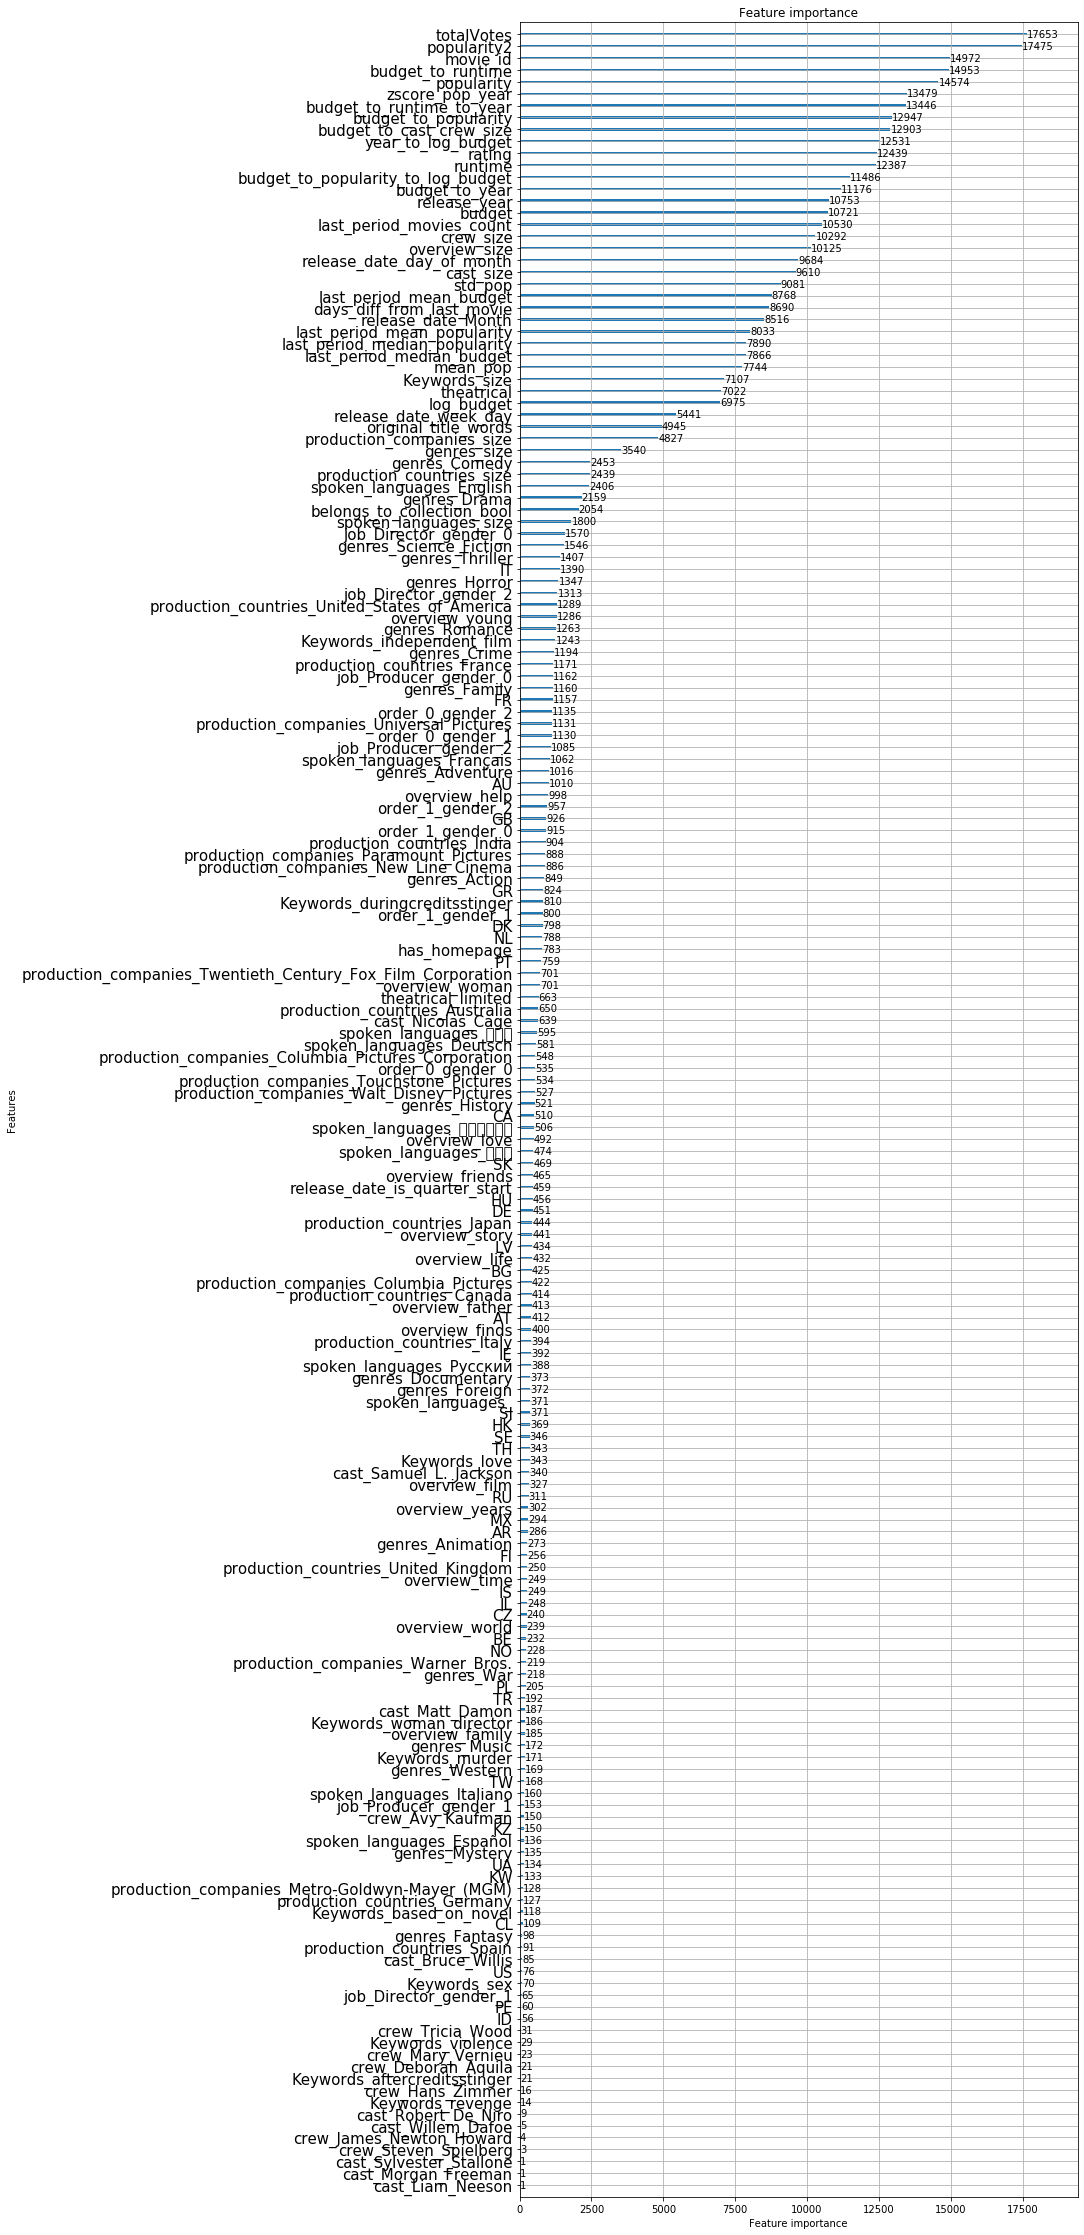

In [34]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.figure(figsize=(20,7))
lgb.plot_importance(lgbmodel,figsize=(10,40))
plt.yticks(fontsize=15)
plt.show()